<a href="https://colab.research.google.com/github/MonikSense/GLAUCOMA/blob/main/grayscaleGaussianBlurCNN3tech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Input folder found: /content/drive/MyDrive/GlaucomaDataset/G1020/Images
✅ First 5 images processed with all three grayscale techniques + Gaussian Blur


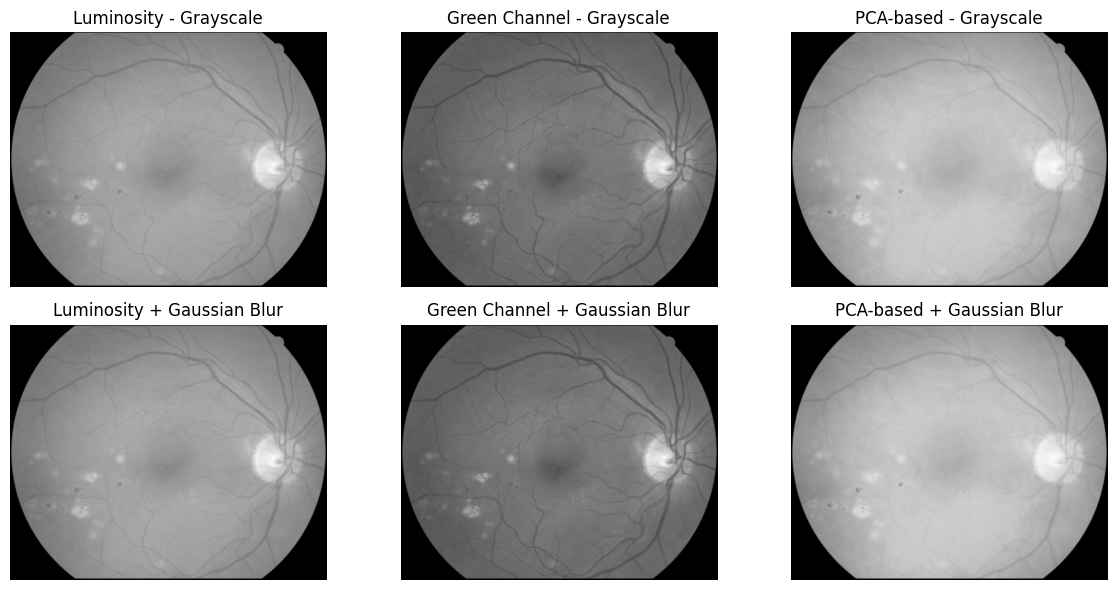

Epoch 1/10 - Loss: 0.189343
Epoch 2/10 - Loss: 0.138435
Epoch 3/10 - Loss: 0.040873
Epoch 4/10 - Loss: 0.010369
Epoch 5/10 - Loss: 0.013000
Epoch 6/10 - Loss: 0.007723
Epoch 7/10 - Loss: 0.003980
Epoch 8/10 - Loss: 0.001857
Epoch 9/10 - Loss: 0.001607
Epoch 10/10 - Loss: 0.001427


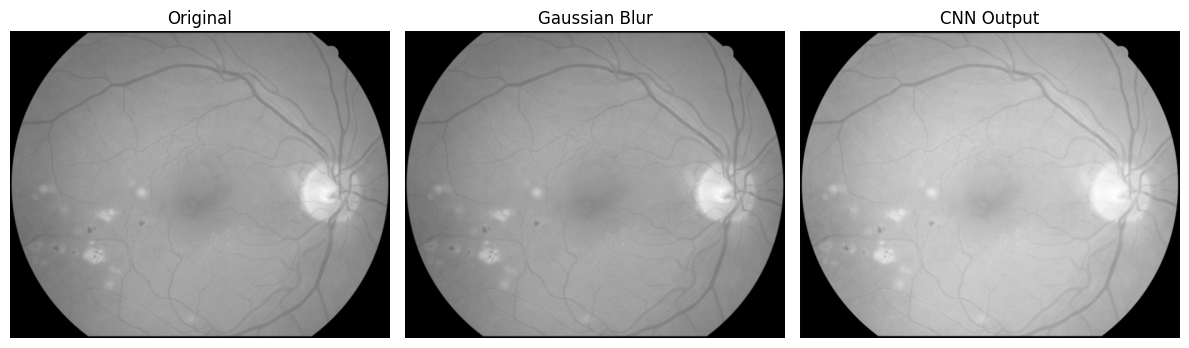

/tmp/ipython-input-401234296.py:179: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_cnn = psnr(original, cnn_output)


ValueError: Since image dtype is floating point, you must specify the data_range parameter. Please read the documentation carefully (including the note). It is recommended that you always specify the data_range anyway.

In [4]:
!pip install scikit-learn scikit-image torch torchvision
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
drive.mount('/content/drive')
# Base directory in your Drive
base_dir = "/content/drive/MyDrive/GlaucomaDataset/G1020"

# Folder to process
folder = "Images"  # change if needed

# Input and output directories
input_dir = os.path.join(base_dir, folder)
output_dir = os.path.join(base_dir, "blurred_first5")
os.makedirs(output_dir, exist_ok=True)

# Verify path
if not os.path.exists(input_dir):
    raise ValueError(f"Input folder does not exist: {input_dir}")
else:
    print("Input folder found:", input_dir)
def grayscale_luminosity(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

def grayscale_green_channel(img_bgr):
    return img_bgr[:, :, 1]

def grayscale_pca(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pixels = img_rgb.reshape(-1,3).astype(np.float32)
    pca = PCA(n_components=1)
    gray = pca.fit_transform(pixels)
    gray = gray.reshape(img_rgb.shape[0], img_rgb.shape[1])
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    return gray.astype(np.uint8)
kernel_size = (7, 7)
sigma = 0
count = 0

# Store one example per technique for visualization
examples = {
    "Luminosity": None,
    "Green Channel": None,
    "PCA-based": None
}

for img_name in os.listdir(input_dir):
    if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img_path = os.path.join(input_dir, img_name)
    img = cv2.imread(img_path)

    if img is None:
        continue

    # --- Grayscale conversions ---
    gray_lum = grayscale_luminosity(img)
    gray_green = grayscale_green_channel(img)
    gray_pca_img = grayscale_pca(img)

    # --- Gaussian Blur ---
    blur_lum = cv2.GaussianBlur(gray_lum, kernel_size, sigma)
    blur_green = cv2.GaussianBlur(gray_green, kernel_size, sigma)
    blur_pca_img = cv2.GaussianBlur(gray_pca_img, kernel_size, sigma)

    # Save only blurred Green Channel (optional)
    cv2.imwrite(os.path.join(output_dir, img_name), blur_green)

    # Store one example for visualization
    if examples["Luminosity"] is None:
        examples["Luminosity"] = (gray_lum, blur_lum)
        examples["Green Channel"] = (gray_green, blur_green)
        examples["PCA-based"] = (gray_pca_img, blur_pca_img)

    count += 1
    if count == 5:
        break

print("✅ First 5 images processed with all three grayscale techniques + Gaussian Blur")
plt.figure(figsize=(12,6))
methods = list(examples.keys())

for i, method in enumerate(methods):
    gray_img, blur_img = examples[method]

    plt.subplot(2,3,i+1)
    plt.imshow(gray_img, cmap="gray")
    plt.title(f"{method} - Grayscale")
    plt.axis("off")

    plt.subplot(2,3,i+4)
    plt.imshow(blur_img, cmap="gray")
    plt.title(f"{method} + Gaussian Blur")
    plt.axis("off")

plt.tight_layout()
plt.show()
class DenoisingCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64,32,3,padding=1), nn.ReLU(),
            nn.Conv2d(32,1,3,padding=1), nn.Sigmoid()
        )
    def forward(self,x):
        return self.decoder(self.encoder(x))
class FundusDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        noisy, clean = self.pairs[idx]
        noisy = torch.tensor(noisy/255., dtype=torch.float32).unsqueeze(0)
        clean = torch.tensor(clean/255., dtype=torch.float32).unsqueeze(0)
        return noisy, clean

# Use Luminosity grayscale for CNN
training_pairs = []
for img_name in os.listdir(input_dir):
    if not img_name.lower().endswith((".jpg", ".png")):
        continue
    img = cv2.imread(os.path.join(input_dir, img_name))
    if img is None: continue
    gray = grayscale_luminosity(img)
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    training_pairs.append((blur, gray))
    if len(training_pairs)==5: break

dataset = FundusDataset(training_pairs)
loader = DataLoader(dataset, batch_size=1, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(10):
    total_loss = 0
    for noisy, clean in loader:
        noisy, clean = noisy.to(device), clean.to(device)
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/10 - Loss: {total_loss:.6f}")
model.eval()
with torch.no_grad():
    noisy, clean = dataset[0]
    noisy = noisy.unsqueeze(0).to(device)
    cnn_output = model(noisy).cpu().squeeze().numpy()
    gaussian = training_pairs[0][0]
    original = training_pairs[0][1]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(original, cmap='gray'); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(gaussian, cmap='gray'); plt.title("Gaussian Blur"); plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(cnn_output, cmap='gray'); plt.title("CNN Output"); plt.axis("off")
plt.tight_layout(); plt.show()
psnr_gauss = psnr(original, gaussian)
psnr_cnn = psnr(original, cnn_output)
ssim_gauss = ssim(original, gaussian)
ssim_cnn = ssim(original, cnn_output)

print(f"PSNR Gaussian: {psnr_gauss:.2f}, CNN: {psnr_cnn:.2f}")
print(f"SSIM Gaussian: {ssim_gauss:.4f}, CNN: {ssim_cnn:.4f}")
